# @dog_rates Data Wrangling Exercise

## Introduction

We will go through the steps of gathering, assessing and cleaning a set of tweets sent out from the @dog_rates user via twitter. We will end with doing some analysis on our cleaned dataset.

## Table of Contents

1. [Gathering Data](#gathering)
2. [Data Assessing](#assess)<br>
    2.1 [Tidiness](#tidy)<br>
    2.2 [Quality Control](#qc)
3. [Data Analysis](#analysis)

## Gathering Data <a class="anchor" id="gathering"></a>

We will utilize python's requests module to download the image prediction tsv file and save locally.

In [1]:
import requests

In [2]:
image_pred_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

req = requests.get(image_pred_url)

with open('image-predictions.tsv', 'wb') as file:
    file.write(req.content)

Now that we have our image prediction file we will use the tweepy module and pull the recount and favorite data points using the twitter api. As tweepy's statuses_lookup function will pull in the tweet info we will use that however it only can provide results for 100 tweets at a time. As such we will load in our twitter-archive-enhanced data and split into a list of lists with each containing 100 tweets. We will then iterate through that list.

First lets load in tweepy and initialize the api.

In [3]:
import tweepy

API_KEY = 'you key here'
API_KEY_SECRET = 'your secret key here'

auth = tweepy.AppAuthHandler(API_KEY, API_KEY_SECRET)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Now we will load in our twitter-archive into a pandas dataframe and then split the tweet id column into a list of lists so we can process each batch as a 100 tweets at a time.

In [4]:
import pandas as pd

twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

search_tweets = twitter_archive['tweet_id'].tolist()

chunks = [search_tweets[i * 100:(i + 1) * 100] for i in range((len(search_tweets) + 100 - 1) // 100 )]

Now we need to iterate through the list of tweets and add each to a list of dictionarys. Then we will use json.dumps to write that list of dictionarys into a .txt file which we can read later instead of having to requery the twitter api.

In [5]:
import json

tweets = []

for chunk in chunks:
    tweet_query = api.statuses_lookup(id_=chunk)
    for tweet in tweet_query:
        tweets.append(tweet._json)

with open('tweet_json.txt', 'w') as file:
    file.write(json.dumps(tweets))

From here we will load in our offline files for assessing the data and ultimately cleaning it up.

In [6]:
import pandas as pd

img_pred_df = pd.read_csv('image-predictions.tsv', sep='\t')
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
tweets = pd.read_json('tweet_json.txt')

## Data Assessing<a class="anchor" id="assess"></a>

Here we will begin our assessment of our tables.

First I will focus on making the tables tidy. I will be focusing on the 2 tweet tables since there will be overlapping data.

### Tidiness<a class="anchor" id="tidy"></a>

In [7]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [8]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   created_at                 2331 non-null   datetime64[ns, UTC]
 1   id                         2331 non-null   int64              
 2   id_str                     2331 non-null   int64              
 3   text                       2331 non-null   object             
 4   truncated                  2331 non-null   bool               
 5   entities                   2331 non-null   object             
 6   source                     2331 non-null   object             
 7   in_reply_to_status_id      77 non-null     float64            
 8   in_reply_to_status_id_str  77 non-null     float64            
 9   in_reply_to_user_id        77 non-null     float64            
 10  in_reply_to_user_id_str    77 non-null     float64            
 11  in_r

From the that pandas info we can see that these 2 tables share a lot of the same columns and are not tidy. Further from the raw tweet files we see that there are quite a few columns which I won't be using as they relate to replies or retweet information. From the raw tweets I will join the `retweet_count` and `favorite_count` to the archived data. I will define this tidiness issues as follows

    - 2 different tables with duplicate/overlapping tweet data
    - Retweet and reply data in the table when only main tweet information is required

In [9]:
# Will use pandas merge to combine the 2 dataframes on the 2 shared keys 
# tweet_id for the archived dataframe and id on the data pulled through tweepy

twitter_archive_enhanced = pd.merge(twitter_archive, tweets[['id', 'retweet_count', 'favorite_count']], 
         how='left', left_on=['tweet_id'], right_on=['id'])

In [10]:
twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

Now from the enhanced dataframe I am going drop columns which won't be specifically useful for looking at the main tweet. `id` will be dropped due to the fact it would be a duplicate of the `tweet_id` column. Additionally I am going to drop the retweeted columns and in_reply columns.

In [11]:
twitter_archive_enhanced.drop(columns=['id'], inplace=True)

for col in twitter_archive_enhanced.columns:
    if "retweeted_" in col or "in_reply_" in col:
        twitter_archive_enhanced.drop(columns=[col], inplace=True)
        
twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2356 non-null   int64  
 1   timestamp           2356 non-null   object 
 2   source              2356 non-null   object 
 3   text                2356 non-null   object 
 4   expanded_urls       2297 non-null   object 
 5   rating_numerator    2356 non-null   int64  
 6   rating_denominator  2356 non-null   int64  
 7   name                2356 non-null   object 
 8   doggo               2356 non-null   object 
 9   floofer             2356 non-null   object 
 10  pupper              2356 non-null   object 
 11  puppo               2356 non-null   object 
 12  retweet_count       2331 non-null   float64
 13  favorite_count      2331 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 276.1+ KB


Now we will look at the image predictions table. As this is predicting the breed of dog we want to use the highest predicted dog. Because there are records which are not predicted as a breed of dog we want to fall back if the highest predicted result is not a dog. For example if p1 is paper towel we fall back to p2 and if p2 is still not a dog we fall back to p3. If no predictions are dogs we will drop the record. I will define this tidiness correction as

     - Remove multiple breed predictions and non-dog predictions from the image prediction table

In [12]:
#We will query the prediction dataframe for the 3 possibilities and join into a single new dataframe with prediction values


p1_dog_predicts = img_pred_df.query('p1_dog==True')[['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf']].rename(columns={'p1': 'prediction', 'p1_conf': 'pred_confidence'})
p2_dog_predicts = img_pred_df.query('p1_dog==False and p2_dog==True')[['tweet_id', 'jpg_url', 'img_num', 'p2', 'p2_conf']].rename(columns={'p2': 'prediction', 'p2_conf': 'pred_confidence'})
p3_dog_predicts = img_pred_df.query('p1_dog==False and p2_dog==False and p3_dog==True')[['tweet_id', 'jpg_url', 'img_num', 'p3', 'p3_conf']].rename(columns={'p3': 'prediction', 'p3_conf': 'pred_confidence'})


#take our 3 dataframes and concatenate them into a single dog prediction dataframe

dog_predicts = pd.concat([p1_dog_predicts, p2_dog_predicts, p3_dog_predicts])

dog_predicts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2026
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tweet_id         1751 non-null   int64  
 1   jpg_url          1751 non-null   object 
 2   img_num          1751 non-null   int64  
 3   prediction       1751 non-null   object 
 4   pred_confidence  1751 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 82.1+ KB


Finally because the image predictions relate to the same tweets we will join our tweet dataframe with our image predictions.

In [13]:
tweets_with_img_pred = pd.merge(twitter_archive_enhanced, dog_predicts, how='left',
                                left_on=['tweet_id'], right_on=['tweet_id'])

We will take this dataframe and go ahead and save to csv so we can reference it in the future.

In [14]:
tweets_with_img_pred.to_csv('twitter_archive_master.csv',index=False)

Now that we have a tidy table to work with we will look into the quality within the dataframe.

### Quality Control<a class="anchor" id="qc"></a>

Lets start by making a copy of our dataset to work on.

In [15]:
tweets_with_img_pred_clean = tweets_with_img_pred.copy()

First I will use pandas info function to see if there are any datatypes which seem incorrect.

In [16]:
tweets_with_img_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2356 non-null   int64  
 1   timestamp           2356 non-null   object 
 2   source              2356 non-null   object 
 3   text                2356 non-null   object 
 4   expanded_urls       2297 non-null   object 
 5   rating_numerator    2356 non-null   int64  
 6   rating_denominator  2356 non-null   int64  
 7   name                2356 non-null   object 
 8   doggo               2356 non-null   object 
 9   floofer             2356 non-null   object 
 10  pupper              2356 non-null   object 
 11  puppo               2356 non-null   object 
 12  retweet_count       2331 non-null   float64
 13  favorite_count      2331 non-null   float64
 14  jpg_url             1751 non-null   object 
 15  img_num             1751 non-null   float64
 16  predic

From this it looks like the timestamp column is a string when it should be datetime. In addition when looking at doggo, floofer, pupper, puppo columns we would want to combine all into one column due to being a single dog state.

   - Erroneous datatype for timestamp
   - Multiple columns for dog state (doggo, floofer, pupper, puppo)

We also notice from our info function call that there are N/As in our dataframe. For the image columns we see quite a few however we will leave those as is, as we purposely excluded non-dog predictions. However we do want to clean up the extended_urls and retweet/favorite_count columns.

   - missing records for expanded_urls
   - missing records for retweet_count and favorite_count

Lets use pandas value_counts function on the rating columns. We know that based on how this account tweets the numerator should be greater than 10 and the denominator should be out of 10.

In [17]:
tweets_with_img_pred_clean['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [18]:
tweets_with_img_pred_clean['rating_numerator'].value_counts().sort_values()

20        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
26        1
182       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
143       1
24        1
204       1
80        1
121       1
75        2
15        2
0         2
420       2
2         9
1         9
4        17
3        19
6        32
5        37
14       54
7        55
8       102
9       158
13      351
10      461
11      464
12      558
Name: rating_numerator, dtype: int64

In both cases we see issues with the data we will want to clean up.

   - rating_numerator has values less than 10
   
   - rating_denominator has values not equal to 10
    
Finally lets look  at the source column as it appears to provide the source of the tweet, iphone, android, etc.

In [19]:
tweets_with_img_pred_clean['source'].value_counts().sort_values()

<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
Name: source, dtype: int64

So we can see that there is a lot of additional infor we don't require. So we will clean up this so it shows only the 4 options used, TweetDeck, Web Client, Vine, iPhone.

   - source column has unnecessary text

Lets take a look at the predicted dog values in from the images.

In [20]:
for i in tweets_with_img_pred_clean['prediction'].value_counts().sort_index(ascending=False).index:
    print(i)


wire-haired_fox_terrier
whippet
vizsla
toy_terrier
toy_poodle
standard_schnauzer
standard_poodle
soft-coated_wheaten_terrier
silky_terrier
schipperke
redbone
pug
papillon
miniature_schnauzer
miniature_poodle
miniature_pinscher
malinois
malamute
kuvasz
komondor
kelpie
keeshond
groenendael
golden_retriever
giant_schnauzer
flat-coated_retriever
dalmatian
curly-coated_retriever
collie
cocker_spaniel
clumber
chow
cairn
bull_mastiff
briard
boxer
borzoi
bluetick
bloodhound
black-and-tan_coonhound
beagle
basset
basenji
Yorkshire_terrier
West_Highland_white_terrier
Welsh_springer_spaniel
Weimaraner
Walker_hound
Tibetan_terrier
Tibetan_mastiff
Sussex_spaniel
Staffordshire_bullterrier
Siberian_husky
Shih-Tzu
Shetland_sheepdog
Scottish_deerhound
Scotch_terrier
Samoyed
Saluki
Saint_Bernard
Rottweiler
Rhodesian_ridgeback
Pomeranian
Pembroke
Pekinese
Old_English_sheepdog
Norwich_terrier
Norwegian_elkhound
Norfolk_terrier
Newfoundland
Mexican_hairless
Maltese_dog
Lhasa
Leonberg
Lakeland_terrier
Labrad

Good news is I don't see any values that are duplicated due to string differences. However we do see some have capital letters and other do not. Let make all these values consistent by making them all lower case.

   - set all predicted dog values to lower case strings

Finally we want to remove any non-original tweets (no retweets or replies to tweets)

   - remove retweets/replies

So my complete list of quality issues to fix are

   - Erroneous datatype for timestamp
   - Multiple columns for dog state (doggo, floofer, pupper, puppo)
   - missing records for expanded_urls
   - missing records for retweet_count and favorite_count
   - rating_numerator has values less than 10
   - rating_denominator has values not equal to 10
   - source column has unnecessary text
   - set all predicted dog values to lower case strings
   - remove retweets/replies
    
We will start with fixing the datatype issue on timestamp.

### Define

- Change the datatype for the timestamp column from a string to a datetime value

### Code

In [21]:
#to fix the timestamp we will use pandas to_datetime function
tweets_with_img_pred_clean['timestamp'] = pd.to_datetime(tweets_with_img_pred_clean['timestamp'])

### Test

To test we will just now rerun our pandas info function.

In [22]:
tweets_with_img_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   int64              
 1   timestamp           2356 non-null   datetime64[ns, UTC]
 2   source              2356 non-null   object             
 3   text                2356 non-null   object             
 4   expanded_urls       2297 non-null   object             
 5   rating_numerator    2356 non-null   int64              
 6   rating_denominator  2356 non-null   int64              
 7   name                2356 non-null   object             
 8   doggo               2356 non-null   object             
 9   floofer             2356 non-null   object             
 10  pupper              2356 non-null   object             
 11  puppo               2356 non-null   object             
 12  retweet_count       2331 non-null 

Now lets fix the 4 dog state columns.

### Define

- Combine the 4 dog state columns into 1 single column representing all states the dog is in

### Code

In [23]:
#to fix the 4 flag columns we will set them as boolean columns. To do this as each column is None or the column header
#I will just make the column equal to where the value is the column header

for flag in ['doggo', 'floofer', 'pupper', 'puppo']:
    tweets_with_img_pred_clean[flag].replace('None', '', inplace=True)
    
tweets_with_img_pred_clean['dog_state'] = tweets_with_img_pred_clean['doggo'] + tweets_with_img_pred_clean['floofer'] + tweets_with_img_pred_clean['pupper'] + tweets_with_img_pred_clean['puppo']

#print the value counts so we can see which unique state values there are as some can overlap
tweets_with_img_pred_clean['dog_state'].value_counts()

                1976
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggofloofer       1
doggopuppo         1
Name: dog_state, dtype: int64

In [24]:
# will map the combined states to be more friendly by updating to seperate by a comma
state_mapping = {
    'doggopupper': 'doggo,pupper',
    'doggofloofer': 'doggo,floofer',
    'doggopuppo': 'doggo,puppo',
    'pupper': 'pupper',
    'puppo': 'puppo',
    'doggo': 'doggo',
    'floofer': 'floofer'
}

for key in state_mapping:
    tweets_with_img_pred_clean.loc[tweets_with_img_pred_clean['dog_state'] == key, 'dog_state'] = state_mapping[key]
    
tweets_with_img_pred_clean['dog_state'].value_counts()

                 1976
pupper            245
doggo              83
puppo              29
doggo,pupper       12
floofer             9
doggo,floofer       1
doggo,puppo         1
Name: dog_state, dtype: int64

### Test

To test we deconstruct or new column into the original and compare to the original dataframe

In [25]:
state_test = tweets_with_img_pred_clean[['tweet_id', 'dog_state']]

deconstruction = []
for row in range(state_test.shape[0]):
    record = {'tweet_id': state_test.iloc[row]['tweet_id']}
    dog_states = state_test.iloc[row]['dog_state'].split(',')
    if dog_states[0] != '':
        for dog_state in dog_states:
            record.update({dog_state: dog_state})
    
    deconstruction.append(record)

    
deconstruction = pd.DataFrame.from_dict(deconstruction).fillna('None')

#compare this with or original dataframe
deconstruction.equals(tweets_with_img_pred[['tweet_id', 'doggo', 'puppo', 'pupper', 'floofer']])

True

Now that our test is good we will drop the 4 old columns from our clean up dataframe.

In [26]:
tweets_with_img_pred_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

tweets_with_img_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   int64              
 1   timestamp           2356 non-null   datetime64[ns, UTC]
 2   source              2356 non-null   object             
 3   text                2356 non-null   object             
 4   expanded_urls       2297 non-null   object             
 5   rating_numerator    2356 non-null   int64              
 6   rating_denominator  2356 non-null   int64              
 7   name                2356 non-null   object             
 8   retweet_count       2331 non-null   float64            
 9   favorite_count      2331 non-null   float64            
 10  jpg_url             1751 non-null   object             
 11  img_num             1751 non-null   float64            
 12  prediction          1751 non-null 

The next issue I will fix is removing the retweets and replies.

### Define

- Remove columns and records which are related to retweets or replies

I dropped the columns which identify those so I will have to reference back to the original dataframe to get the records which are retweets or replies to other tweets.


### Code

In [27]:
#first we reference the original dataframe and get the retweet/replies and then we will combine and then use a mask to remove
#them from our dataframe
reply_id = twitter_archive[~twitter_archive['in_reply_to_status_id'].isnull()]['tweet_id']
retweet_id = twitter_archive[~twitter_archive['retweeted_status_id'].isnull()]['tweet_id']


reply_retweet_id = pd.concat([reply_id, retweet_id])

tweets_with_img_pred_clean = tweets_with_img_pred_clean[~tweets_with_img_pred_clean['tweet_id'].isin(reply_retweet_id)]


### Test

In [28]:
tweets_with_img_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   int64              
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                2097 non-null   object             
 8   retweet_count       2090 non-null   float64            
 9   favorite_count      2090 non-null   float64            
 10  jpg_url             1666 non-null   object             
 11  img_num             1666 non-null   float64            
 12  prediction          1666 non-null 

Now I will make our dog predictions all lower case to be consistent.

### Define

- Update so all dog predictions are lower case

### Code

In [29]:
tweets_with_img_pred_clean['prediction'] =tweets_with_img_pred_clean['prediction'].str.lower()

### Test

We will print each and just do a visual inspection

In [30]:
for i in tweets_with_img_pred_clean['prediction'].value_counts().sort_index(ascending=False).index:
    print(i)

yorkshire_terrier
wire-haired_fox_terrier
whippet
west_highland_white_terrier
welsh_springer_spaniel
weimaraner
walker_hound
vizsla
toy_terrier
toy_poodle
tibetan_terrier
tibetan_mastiff
sussex_spaniel
standard_schnauzer
standard_poodle
staffordshire_bullterrier
soft-coated_wheaten_terrier
silky_terrier
siberian_husky
shih-tzu
shetland_sheepdog
scottish_deerhound
scotch_terrier
schipperke
samoyed
saluki
saint_bernard
rottweiler
rhodesian_ridgeback
redbone
pug
pomeranian
pembroke
pekinese
papillon
old_english_sheepdog
norwich_terrier
norwegian_elkhound
norfolk_terrier
newfoundland
miniature_schnauzer
miniature_poodle
miniature_pinscher
mexican_hairless
maltese_dog
malinois
malamute
lhasa
leonberg
lakeland_terrier
labrador_retriever
kuvasz
komondor
kelpie
keeshond
japanese_spaniel
italian_greyhound
irish_wolfhound
irish_water_spaniel
irish_terrier
irish_setter
ibizan_hound
groenendael
greater_swiss_mountain_dog
great_pyrenees
great_dane
gordon_setter
golden_retriever
giant_schnauzer
germ

So we have made a lot of progress quickly with our clean up efforts. Lets see what we have left.
   
   - ~~Erroneous datatype for timestamp~~
   - ~~Multiple columns for dog state (doggo, floofer, pupper, puppo)~~
   - missing records for expanded_urls
   - missing records for retweet_count and favorite_count
   - rating_numerator has values less than 10
   - rating_denominator has values not equal to 10
   - source column has unnecessary text
   - ~~set all predicted dog values to lower case strings~~
   - ~~remove retweets/replies~~

Lets take care of the missing data next. 

### Define

- Remove the missing records for expanded_urls

### Code

The number of records missing the 3 values are very small so lets take a look at them. I suspect based on how we joined the count information that the missing data for retweet/favorite count overlap of the same records so will check that first.

In [31]:
(tweets_with_img_pred_clean.query('retweet_count.isnull()').index != tweets_with_img_pred_clean.query('favorite_count.isnull()').index).sum()

0

We can see that they are all the same records so we will store those in a dataframe and we will store the missing expanded_urls in a dataframe for easy reference.

In [32]:
missing_ex_urls = tweets_with_img_pred_clean.query('expanded_urls.isnull()')

In [33]:
missing_counts = tweets_with_img_pred_clean.query('retweet_count.isnull() or favorite_count.isnull()')

In [34]:
missing_ex_urls

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,img_num,prediction,pred_confidence,dog_state
375,828361771580813312,2017-02-05 21:56:51+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Beebop and Doobert should start a band 12/10 w...,NaN,12,10,None,172.0,2135.0,NaN,NaN,NaN,NaN,
707,785515384317313025,2016-10-10 16:20:36+00:00,"<a href=""http://twitter.com/download/iphone"" r...","Today, 10/10, should be National Dog Rates Day",NaN,10,10,None,1229.0,6027.0,NaN,NaN,NaN,NaN,
1445,696518437233913856,2016-02-08 02:18:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Oh my god 10/10 for every little hot dog pupper,NaN,10,10,None,1647.0,3780.0,NaN,NaN,NaN,NaN,pupper


There are only 3 records missing for expanded_urls so we will take a look at that issue first. First we need to understand what the expanded_urls are. So lets take a look at one which is not missing.

In [35]:
for value in tweets_with_img_pred_clean.iloc[4][['tweet_id', 'expanded_urls']]:
    print(value)

891327558926688256
https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1


What we see is that those expanded_urls values they are the url for the photo(s) of the dog being rated, or additional urls in the tweet. Because there are only 3 cases of this we can quickly just check those tweets. Upon a manual visualization of the tweet on twitter we see that all 3 of these tweets actually are not in reference to rating a dog but something dog related. As these 3 tweets do not relate directly to a dog rating instead of populating the missing expanded_urls we will drop the records from the dataframe.

In [36]:
tweets_with_img_pred_clean.drop(missing_ex_urls.index, axis=0, inplace=True)

### Test

In [37]:
tweets_with_img_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2094 non-null   int64              
 1   timestamp           2094 non-null   datetime64[ns, UTC]
 2   source              2094 non-null   object             
 3   text                2094 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2094 non-null   int64              
 6   rating_denominator  2094 non-null   int64              
 7   name                2094 non-null   object             
 8   retweet_count       2087 non-null   float64            
 9   favorite_count      2087 non-null   float64            
 10  jpg_url             1666 non-null   object             
 11  img_num             1666 non-null   float64            
 12  prediction          1666 non-null 

Now lets looks into the tweets missing retweet and favorite counts.

### Define

- Update or remove the records with missing retweet and favorite counts

### Code

Lets reference our missing counts that we stored earlier

In [38]:
missing_counts

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,img_num,prediction,pred_confidence,dog_state
104,872261713294495745,2017-06-07 01:19:32+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Harry. His ears are activated one at a...,https://twitter.com/dog_rates/status/872261713...,13,10,Harry,NaN,NaN,https://pbs.twimg.com/media/DBrlZk2UQAAfAkd.jpg,2.0,labrador_retriever,0.972019,
253,844704788403113984,2017-03-23 00:18:10+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Luna. It's her first time outside and ...,https://twitter.com/dog_rates/status/844704788...,13,10,Luna,NaN,NaN,https://pbs.twimg.com/media/C7j-hkSW0AIxCZC.jpg,1.0,labrador_retriever,0.980213,
296,837366284874571778,2017-03-02 18:17:34+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Lucy. She has a portrait of herself on...,https://twitter.com/dog_rates/status/837366284...,13,10,Lucy,NaN,NaN,https://pbs.twimg.com/media/C57sMJwXMAASBSx.jpg,1.0,american_staffordshire_terrier,0.660085,
363,829374341691346946,2017-02-08 17:00:26+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Astrid. She's a guide doggo in trainin...,https://twitter.com/dog_rates/status/829374341...,13,10,Astrid,NaN,NaN,https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg,1.0,staffordshire_bullterrier,0.757547,doggo
750,779123168116150273,2016-09-23 01:00:13+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Reggie. He hugs everyone he meets. 12/...,https://twitter.com/dog_rates/status/779123168...,12,10,Reggie,NaN,NaN,https://pbs.twimg.com/media/CtAAYizW8AAWzBZ.jpg,1.0,toy_poodle,0.431080,
932,754011816964026368,2016-07-15 17:56:40+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Charlie. He pouts until he gets to go ...,https://twitter.com/dog_rates/status/754011816...,12,10,Charlie,NaN,NaN,https://pbs.twimg.com/media/CnbJuPoXEAAjcVF.jpg,1.0,french_bulldog,0.600985,
1726,680055455951884288,2015-12-24 16:00:30+00:00,"<a href=""https://about.twitter.com/products/tw...","Meet Sammy. At first I was like ""that's a snow...",https://twitter.com/dog_rates/status/680055455...,10,10,Sammy,NaN,NaN,https://pbs.twimg.com/media/CW-ZRC_WQAAyFrL.jpg,1.0,samoyed,0.995466,


Due to the manageable number of records I did some manual investigation and these tweets do not exist. This could have been deleted after being tweeted. As such we will just drop these records from our dataframe.

In [39]:
tweets_with_img_pred_clean.drop(missing_counts.index, axis=0, inplace=True)

### Test

In [40]:
tweets_with_img_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2087 entries, 0 to 2355
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2087 non-null   int64              
 1   timestamp           2087 non-null   datetime64[ns, UTC]
 2   source              2087 non-null   object             
 3   text                2087 non-null   object             
 4   expanded_urls       2087 non-null   object             
 5   rating_numerator    2087 non-null   int64              
 6   rating_denominator  2087 non-null   int64              
 7   name                2087 non-null   object             
 8   retweet_count       2087 non-null   float64            
 9   favorite_count      2087 non-null   float64            
 10  jpg_url             1659 non-null   object             
 11  img_num             1659 non-null   float64            
 12  prediction          1659 non-null 

Now we are to the fun part. We identified numerators below 10, when most should be above 10, and denominators that do not equal 10. So we will be focus on only the cases which fall outside these rules.

### Define

- Update denominators to reflect the right rating and be out of 10

### Code

First we will use the denominators since we would expect most to be out of 10.

In [41]:
not_10_denominator = tweets_with_img_pred_clean.query('rating_denominator != 10')

not_10_denominator.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 433 to 2335
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            17 non-null     int64              
 1   timestamp           17 non-null     datetime64[ns, UTC]
 2   source              17 non-null     object             
 3   text                17 non-null     object             
 4   expanded_urls       17 non-null     object             
 5   rating_numerator    17 non-null     int64              
 6   rating_denominator  17 non-null     int64              
 7   name                17 non-null     object             
 8   retweet_count       17 non-null     float64            
 9   favorite_count      17 non-null     float64            
 10  jpg_url             16 non-null     object             
 11  img_num             16 non-null     float64            
 12  prediction          16 non-null   

There are 17 cases of the denominator not equalling 10. Will examine the text for each of these tweets to see if this is an issue in the data extracted or is correct.

In [42]:
for i in range(17):
    print(not_10_denominator.iloc[i]['text'], '\n')

The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd 

Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx 

Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE 

After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ 

Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv 

Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a 

This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq 

Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1 

Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co

From this I see some are valid but others looke to be pulling out the incorrect values, likely due to using regular expressions the first fraction found was pulled out. So we will pull out the correct value in addition to make this consistent we will adjust all so the denominator is out of 10, ie 121/110 will be 11/10.

First lets devise a way to pull out the correct ratings then we will normalize to out of 10. Looking at each of the texts in cases where there are 2 fractions the rating is always the second one. So we will use regular expressions to pull out each of the fractions and if more than 2 use the second case.

In [43]:
import re

ratings_clean = []

for i in range(17):
    tweet_id = not_10_denominator.iloc[i]['tweet_id']
    ratings = re.findall(r'([0-9]+)\/([0-9]+)', not_10_denominator.iloc[i]['text'])
    if len(ratings) != 1:
        rating_numerator = int(ratings[1][0])
        rating_denominator = int(ratings[1][1])
    else:
        rating_numerator = int(ratings[0][0])
        rating_denominator = int(ratings[0][1])
    
    if rating_denominator != 10:
        norm = 10/rating_denominator
        rating_numerator = rating_numerator * norm
        #we will do the same transform on our denominator for sanity check as shoudl be out of 10
        rating_denominator = rating_denominator * norm
    
    #we will append these values to our clean list and then update our dataframe with them
    ratings_clean.append({
        'tweet_id': tweet_id,
        'rating_numerator': int(rating_numerator),
        'rating_denominator': int(rating_denominator)
    })

Now we just need to update our existing dataframe with these cleaned ratings.

In [44]:
for i in ratings_clean:
    tweets_with_img_pred_clean.loc[tweets_with_img_pred_clean['tweet_id']==i['tweet_id'],'rating_numerator'] = i['rating_numerator']
    tweets_with_img_pred_clean.loc[tweets_with_img_pred_clean['tweet_id']==i['tweet_id'], 'rating_denominator'] = i['rating_denominator']

### Test

In [45]:
tweets_with_img_pred_clean['rating_denominator'].value_counts()

10    2087
Name: rating_denominator, dtype: int64

Now we have all denominators out of 10 in our dataframe. Let us now look at the numerators under 10.

### Define

- Update any incorrect numerators in our numerator column

### Code

In [46]:
numerator_less_10 = tweets_with_img_pred_clean.query('rating_numerator < 10')

numerator_less_10['rating_numerator'].value_counts()

9    154
8     98
7     51
5     34
6     32
3     19
4     15
2      9
1      4
0      1
Name: rating_numerator, dtype: int64

There are too many cases for us to manually look through because this is not a strict rule many of these are likely valid. We know we already fixed a few when we fixed the denominators. To see if there are any cases where there are 2 fractions in the text I will loop through similar to our denominator process to make sure the correct fraction was pulled in.

Because there are far more cases and we don't know what we are working with for each case, the denominators we could see with our eyes but way to many to do this, we will use more robust loop to take the last case for our regex.

In [47]:
ratings_clean = []

for i in range(numerator_less_10.shape[0]):
    tweet_id = numerator_less_10.iloc[i]['tweet_id']
    ratings = re.findall(r'([0-9]+)\/([0-9]+)', numerator_less_10.iloc[i]['text'])
    counts = len(ratings)
    rating_numerator = int(ratings[counts - 1][0])
    rating_denominator = int(ratings[counts - 1][1])

    
    #we will append these values to our clean list and then update our dataframe with them
    ratings_clean.append({
        'tweet_id': tweet_id,
        'rating_numerator': int(rating_numerator),
        'rating_denominator': int(rating_denominator)
    })
    
for i in ratings_clean:
    tweets_with_img_pred_clean.loc[tweets_with_img_pred['tweet_id']==i['tweet_id'],'rating_numerator'] = i['rating_numerator']
    tweets_with_img_pred_clean.loc[tweets_with_img_pred['tweet_id']==i['tweet_id'], 'rating_denominator'] = i['rating_denominator']

Now we will check if that clean up any of our numerators.

### Test

In [48]:
numerator_less_10 = tweets_with_img_pred_clean.query('rating_numerator < 10')

numerator_less_10['rating_numerator'].value_counts()

9    152
8     98
7     50
6     32
5     32
3     19
4     14
2     10
1      5
0      1
Name: rating_numerator, dtype: int64

So this does look to have cleaned up a few of the cases not very many. However given that the rule is not strict with the numerator being greater than 10 we will consider what is there now as valid.

Finally lets clean up our source column. 

### Define

- Update the source column to remove the additional unneccessary markup text

To do this we have alot of additional data but all we care about the actual source it came from.

To do this I will create a mapping of the 4 values then apply that to the column.

### Code

In [49]:
mapping = {'<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>':'TweetDeck',
'<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>':'Web Client',
'<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>': 'Vine',
'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>': 'iPhone'}

tweets_with_img_pred_clean.replace({'source':mapping}, inplace=True)

### Test

In [50]:
tweets_with_img_pred_clean['source'].value_counts()

iPhone        1956
Vine            91
Web Client      30
TweetDeck       10
Name: source, dtype: int64

Now that we have cleaned up our data I have realized 2 additional things can be done to make it more tidy. One we can remove the `expanded_urls` completely as the `jpg_url` column has the image used for the prediction so we this would mean these are duplicated columns. Additionally we can drop the `rating_denominator` column as they are all out of 10 now, but we will rename our numerator to show it is out of 10.

### Define

- Remove unnecessary/duplicated data columns

### Code

In [51]:
tweets_with_img_pred_clean.drop(columns=['expanded_urls', 'rating_denominator'], inplace=True)

tweets_with_img_pred_clean.rename(columns={'rating_numerator': 'rating_out_of_10'}, inplace=True)

### Test

In [52]:
tweets_with_img_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2087 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   tweet_id          2087 non-null   int64              
 1   timestamp         2087 non-null   datetime64[ns, UTC]
 2   source            2087 non-null   object             
 3   text              2087 non-null   object             
 4   rating_out_of_10  2087 non-null   int64              
 5   name              2087 non-null   object             
 6   retweet_count     2087 non-null   float64            
 7   favorite_count    2087 non-null   float64            
 8   jpg_url           1659 non-null   object             
 9   img_num           1659 non-null   float64            
 10  prediction        1659 non-null   object             
 11  pred_confidence   1659 non-null   float64            
 12  dog_state         2087 non-null   object             
dtypes: 

Now that we have done that we will resave our clean dataframe into a csv for future reference.

In [53]:
tweets_with_img_pred_clean.to_csv('twitter_archive_master.csv',index=False)

tweets_with_img_pred = pd.read_csv('twitter_archive_master.csv')

## Data Analysis<a class="anchor" id="analysis"></a>

No that we have our data wrangled lets take a look at what we are working with. I will look at the following items.

- Which of the dog states (doggo, floofer, pupper, puppo) result in a higher retweet and favorite count?
- Does the rating appear to lead to a higher retweet and favorite count?
- Of the predicted dog breeds which has the highest rating?

To ask these questions we will look at descriptive statistics, along with logistic regression, and utilize some graphs.

In [54]:
tweets_with_img_pred.groupby('dog_state')[['retweet_count', 'favorite_count']].mean()

,retweet_count,favorite_count
dog_state,,
doggo,5794.591549,16973.197183
"doggo,floofer",2936.000000,15396.000000
"doggo,pupper",3747.333333,12519.555556
"doggo,puppo",16789.000000,43323.000000
floofer,3494.111111,9772.000000
pupper,2111.104545,6499.518182
puppo,5686.347826,20286.956522


We see from this that the puppo flag appears to have the mean for both retweet and favorite counts.

Let's fit a quick linear regression model to see how they predict both retweet and favorite counts.

In [55]:
import statsmodels.api as sm

model_data = tweets_with_img_pred[['dog_state', 'retweet_count', 'favorite_count']]

model_data['intercept'] = 1

model_data = pd.concat([model_data, pd.get_dummies(model_data['dog_state'])], axis=1)

# we will not use to doggo column to be full rank
model_retweet = sm.OLS(model_data['retweet_count'], model_data[['pupper', 'puppo', 'floofer', 'doggo,floofer', 'doggo,pupper', 'doggo,puppo','intercept']].astype(int))
model_favorite = sm.OLS(model_data['favorite_count'], model_data[['pupper', 'puppo', 'floofer', 'doggo,floofer', 'doggo,pupper', 'doggo,puppo', 'intercept']].astype(int))

results_retweet = model_retweet.fit()
results_favorite = model_favorite.fit()

<ipython-input-55-0213c73e5376>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['intercept'] = 1


In [56]:
results_retweet.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          retweet_count   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     4.687
Date:                Sat, 20 Feb 2021   Prob (F-statistic):           9.55e-05
Time:                        17:11:24   Log-Likelihood:                -20378.
No. Observations:                2087   AIC:                         4.077e+04
Df Residuals:                    2080   BIC:                         4.081e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
pupper         -287.1882    300.988     -0.954      0.340    -877.458     303.081
puppo          3288.0551    884.891      3.716      0.000    1552.690    5023.420
floofer        1095.8183   1409.225      0.778      0.437   -1667.820    3859.457
doggo,floofer   537.7072   4218.440      0.127      0.899   -7735.097    8810.511
doggo,pupper   1349.0406   1409.225      0.957      0.339   -1414.598    4112.679
doggo,puppo    1.439e+04   4218.440      3.411      0.001    6117.903    2.27e+04
intercept      2398.2928     98.746     24.287      0.000    2204.641    2591.944
==============================================================================
Omnibus:                     2701.010   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           547814.330
Skew:                           6.992   Prob(JB):                         0.00
Kurtosis:                      81.129   Cond. No.                         46.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
results_favorite.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     6.697
Date:                Sat, 20 Feb 2021   Prob (F-statistic):           4.90e-07
Time:                        17:11:24   Log-Likelihood:                -22503.
No. Observations:                2087   AIC:                         4.502e+04
Df Residuals:                    2080   BIC:                         4.506e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
pupper        -1579.1041    833.091     -1.895      0.058   -3212.884      54.675
puppo          1.221e+04   2449.249      4.985      0.000    7405.099     1.7e+04
floofer        1693.3777   3900.528      0.434      0.664   -5955.969    9342.724
doggo,floofer  7317.3777   1.17e+04      0.627      0.531   -1.56e+04    3.02e+04
doggo,pupper   4440.9333   3900.528      1.139      0.255   -3208.413    1.21e+04
doggo,puppo    3.524e+04   1.17e+04      3.019      0.003    1.23e+04    5.81e+04
intercept      8078.6223    273.315     29.558      0.000    7542.623    8614.622
==============================================================================
Omnibus:                     1940.690   Durbin-Watson:                   1.260
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            90044.732
Skew:                           4.341   Prob(JB):                         0.00
Kurtosis:                      33.986   Cond. No.                         46.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Lets look at how the ratings compares with the retweets and favorite counts. To do this we will bin the ratings then look at the mean of the retweet and favorite count.

In [58]:
ratings_with_counts = tweets_with_img_pred[['rating_out_of_10', 'retweet_count', 'favorite_count']]

ratings_with_counts['bins'] = pd.cut(ratings_with_counts['rating_out_of_10'], 
                                     bins=[0, 5, 10, 15, 20, 25, 1500, 2000])


<ipython-input-58-4f64e5d25438>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_with_counts['bins'] = pd.cut(ratings_with_counts['rating_out_of_10'],


In [59]:
ratings_with_counts.groupby('bins')[['retweet_count', 'favorite_count']].mean()

,retweet_count,favorite_count
bins,,
"(0, 5]",1077.162500,2916.675000
"(5, 10]",1063.967448,3068.106771
"(10, 15]",3353.398050,11550.102356
"(15, 20]",NaN,NaN
"(20, 25]",NaN,NaN
"(25, 1500]",3002.500000,9448.666667
"(1500, 2000]",2378.000000,4952.000000


Based on looking at the groups of rating and the mean of each group we see that high mean counts are in the bins with higher rating. Lets look at a scatter plot to see the individual points.

In [60]:
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

Text(0, 0.5, 'Retweet Count')

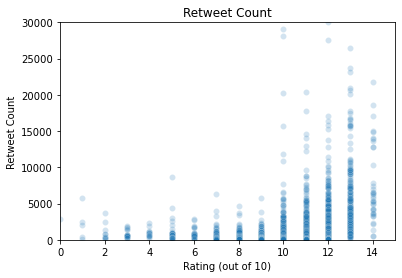

In [61]:
sb.scatterplot(data=ratings_with_counts, x='rating_out_of_10', y ='retweet_count', alpha=.2);
#we will set the x limit to be between 0 and 15 since we know that there are a few outliers based on our group
# additionally we will set a limit on the y axis bewteen 0 and 30000
plt.xlim([0, 15]);
plt.ylim([0, 30000])
plt.title('Retweet Count');
plt.xlabel('Rating (out of 10)')
plt.ylabel('Retweet Count')

Text(0, 0.5, 'Favorite Count')

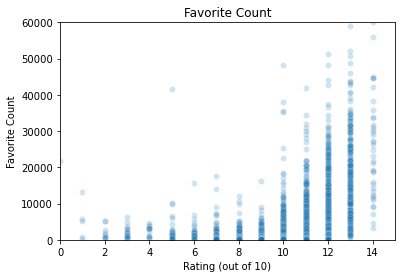

In [62]:
sb.scatterplot(data=ratings_with_counts, x='rating_out_of_10', y ='favorite_count', alpha=.2);
plt.xlim([0, 15]);
plt.ylim([0, 60000])
plt.title('Favorite Count');
plt.xlabel('Rating (out of 10)')
plt.ylabel('Favorite Count')

From these visuals along with our group by on means we can see that there does appear to be a general relationship between a higher rating and greater retweet and favorite counts.

Now lets look at based on our predicted dog values which has the highest rating/retweet/favorite values.

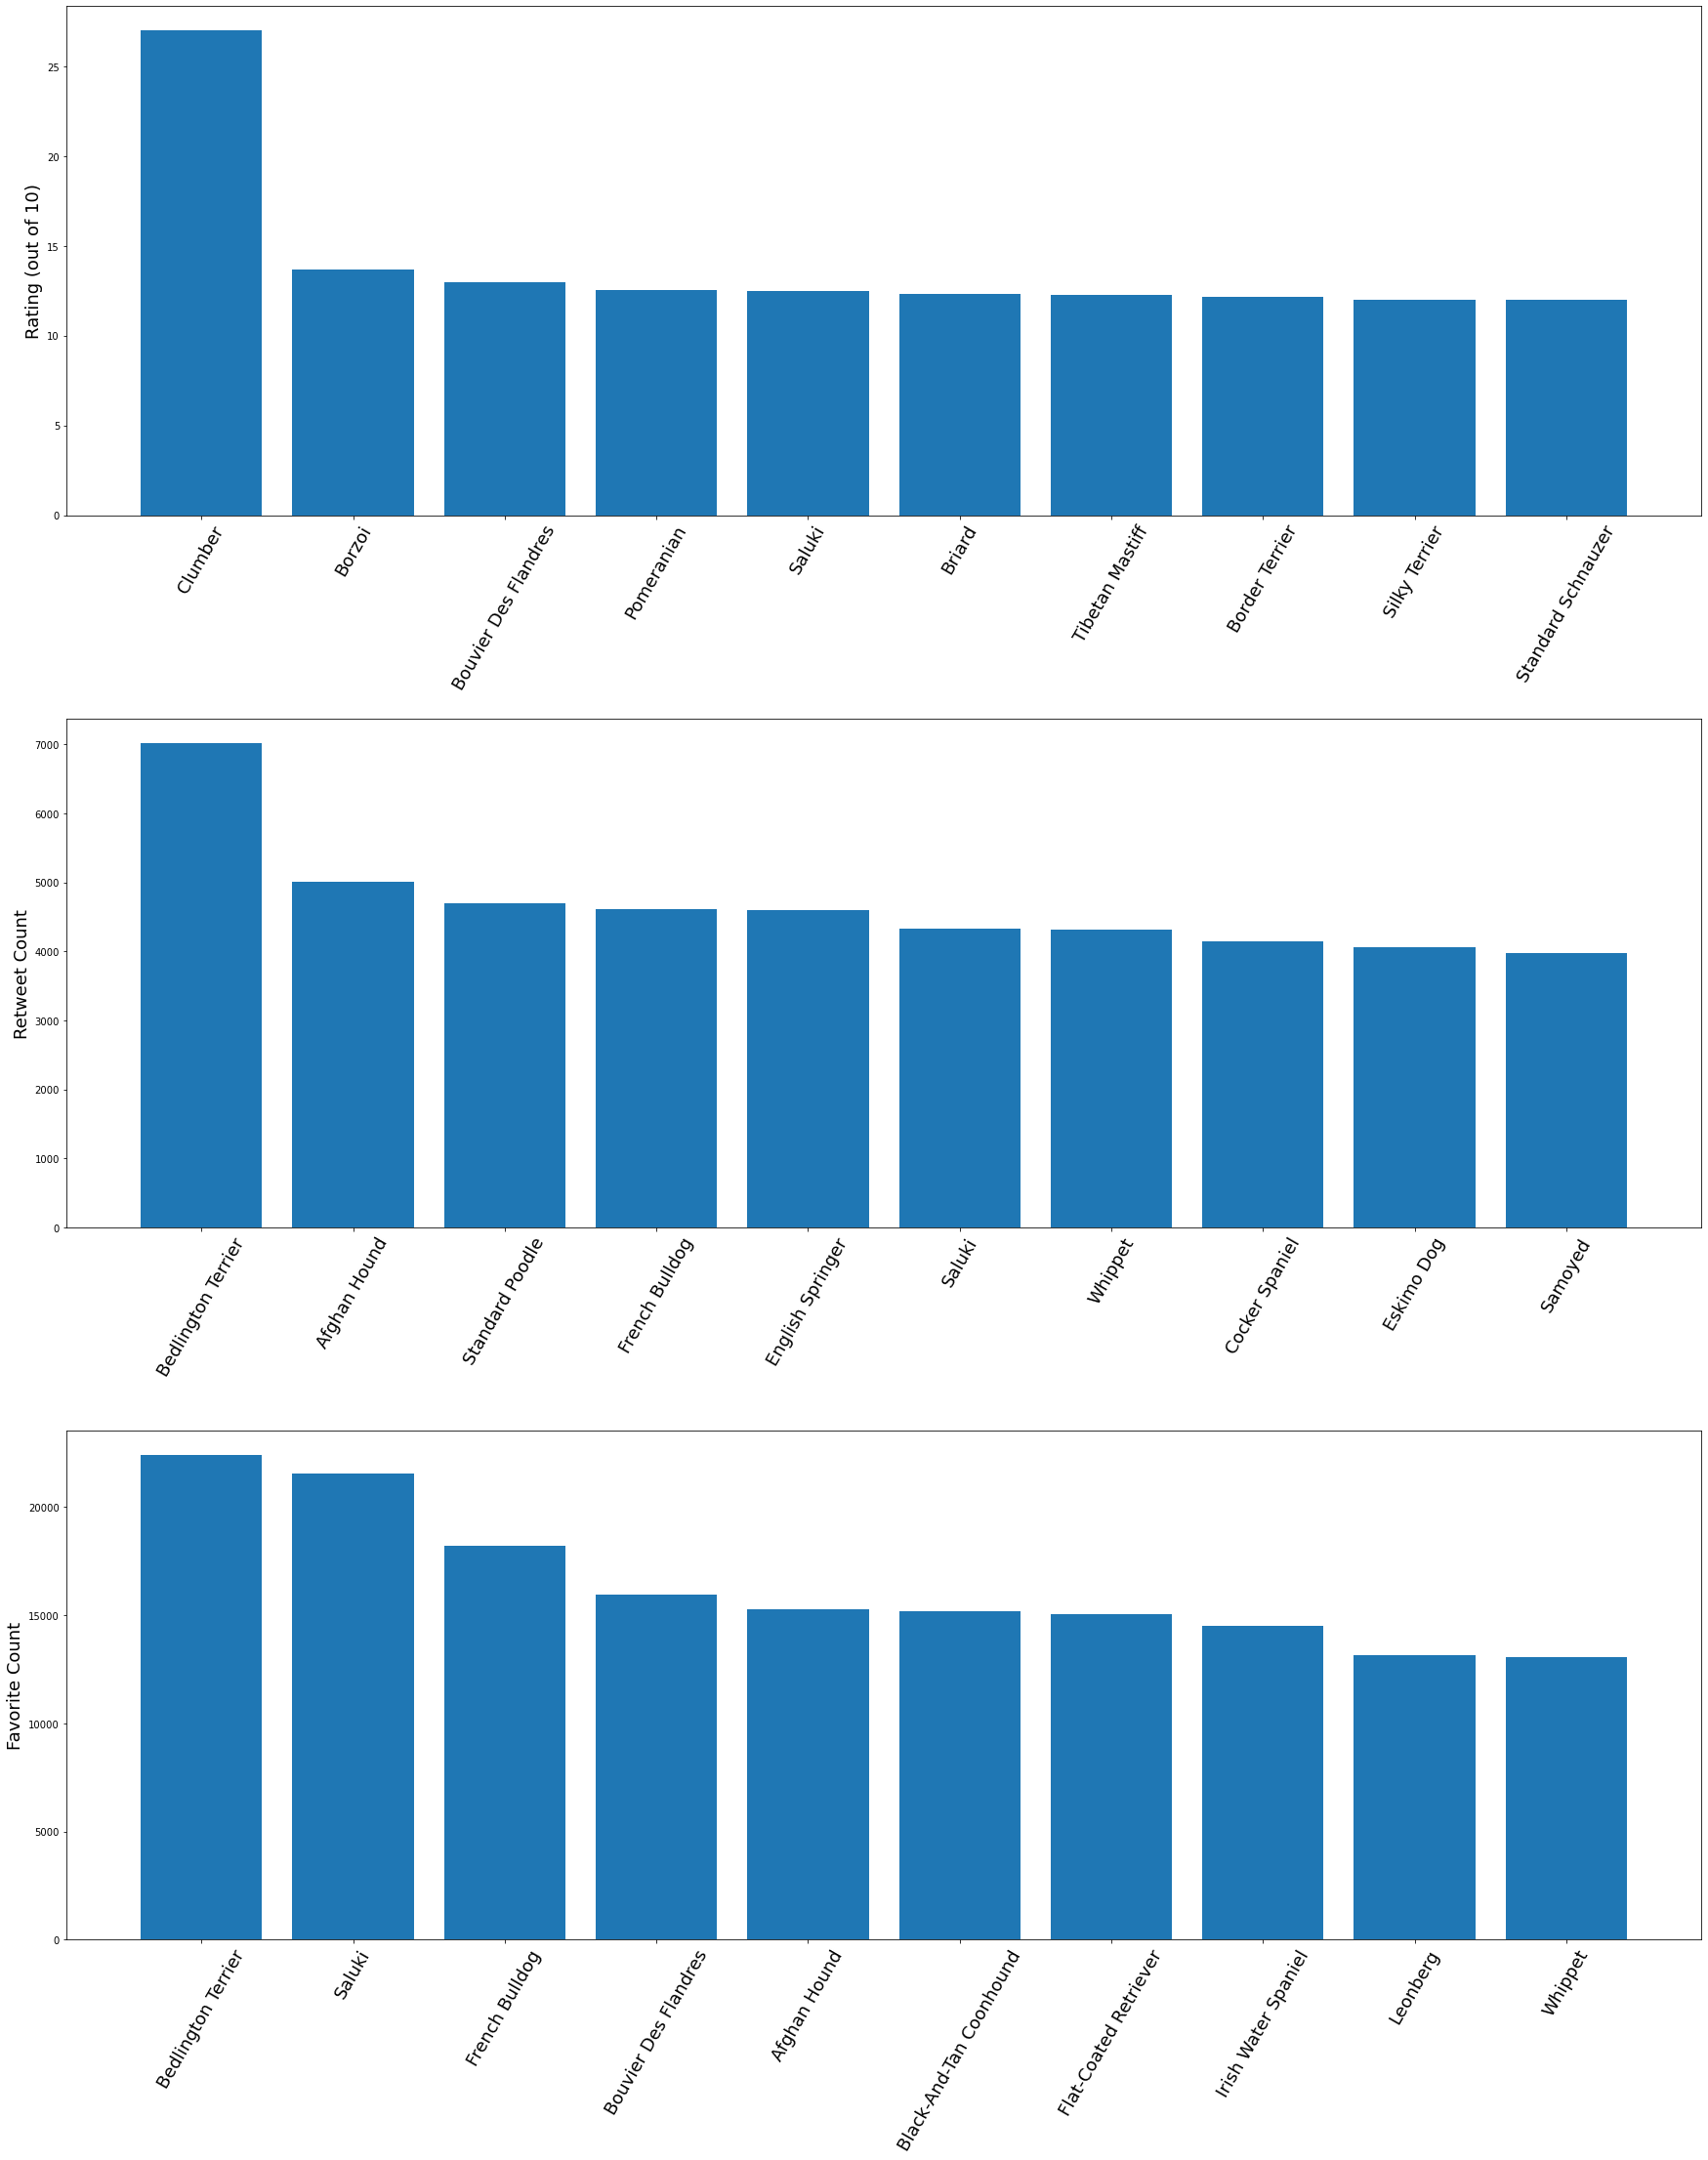

In [63]:
breed_groups = tweets_with_img_pred.query('~prediction.isnull()').groupby('prediction')[['rating_out_of_10', 'retweet_count', 'favorite_count']].mean()
breed_groups.index = breed_groups.index.str.replace("_", " ").str.title()
#lets graph the top 10 for each of the 3 metrics.
# to do this we will sort by each column grab the first 10 and put in a set then graph each of the metrics


cols = ['rating_out_of_10', 'retweet_count', 'favorite_count']
cols_pretty = ['Rating (out of 10)', 'Retweet Count', 'Favorite Count']

plt.figure(figsize=(30, 20));
plt.subplots_adjust(top=1.5, hspace=.4)

for i in range(3):
    plt.subplot(3, 1, i+1);
    top_performers = breed_groups.sort_values(by=[cols[i]], ascending=False).iloc[0:10]
    plt.bar(top_performers.index, top_performers[cols[i]]);
    plt.ylabel(cols_pretty[i], fontsize=18);
    plt.xticks(rotation=60, fontsize=18);

plt.show();